In [1]:
import warnings
warnings.filterwarnings('ignore')
from itertools import izip

from IPython import get_ipython;   
get_ipython().magic('reset -sf')

import numpy as np
from warnings import warn
import matplotlib
import matplotlib.pyplot as plt
import itertools

import seaborn as sns
from matplotlib import colors
from matplotlib import animation
from IPython.display import HTML

HTML("""
<style>
 {
    display: table-cell;
    text-align: center;
   .output_png vertical-align: middle;http://localhost:8888/notebooks/DynamicCalcium.ipynb#
}
</style>
""")

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 85%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))
from shapely.geometry import Polygon

In [2]:
# Load shape file and adjacency matrices
adj_map=np.load("../VoronoiSahpeFiles/epitools/adj_map.npy").item()
adj_length_matrix=np.load("../VoronoiSahpeFiles/epitools/adj_length_matrix.npy")
new_vertices=np.load("../VoronoiSahpeFiles/epitools/new_vertices.npy")
area_profile=np.load("../VoronoiSahpeFiles/epitools/area_profile.npy")

#Form Laplacian and adj matix
laplacian_matrix=np.copy(adj_length_matrix)
for j in xrange(adj_length_matrix.shape[0]):
    laplacian_matrix[j,j]=-1.0*np.sum(adj_length_matrix[j,:])
adj_matrix= (laplacian_matrix>0).astype(int)

small_pouch_index=[]
centeriods= np.zeros((adj_length_matrix.shape[0],2))
for j in xrange(adj_length_matrix.shape[0]):
    x_center, y_center=new_vertices[j].mean(axis=0)
    #print(x_center,y_center)
    centeriods[j,0],centeriods[j,1]=x_center, y_center
    if (x_center-800)**2/2.0+(y_center+500)**2<500000:
        small_pouch_index.append(j)



In [3]:
perimeter_profile=np.zeros_like(area_profile)
for j in xrange(perimeter_profile.size):
    perimeter_profile[j]=Polygon(new_vertices[j]).length

In [4]:
small_pouch_index=np.array(small_pouch_index)

adj_length_matrix=adj_length_matrix[small_pouch_index,:]
adj_length_matrix=adj_length_matrix[:,small_pouch_index]
new_vertices=new_vertices[small_pouch_index]
new_area_profile=area_profile[small_pouch_index]
#Form Laplacian and adj matix
laplacian_matrix=np.copy(adj_length_matrix)
for j in xrange(adj_length_matrix.shape[0]):
    laplacian_matrix[j,j]=-1.0*np.sum(adj_length_matrix[j,:])
adj_matrix= (laplacian_matrix>0).astype(int)


In [5]:
adj_matrix_two=np.zeros_like(adj_matrix)
for i in xrange(adj_length_matrix.shape[0]):
    neighs_i=np.where(adj_matrix[i,:]==1)[0]
    adj_matrix_two[i,neighs_i]=1
    for j in neighs_i:
        neighs_j=np.where(adj_matrix[j,:]==1)[0]
        adj_matrix_two[i,neighs_j]=1
        adj_matrix_two[i,i]=0
        

In [6]:
#Mechanistic Model Parameters
n_cells= adj_matrix.shape[0]
dt=.2
T=int(3600/dt)

K_PLC=.2#0.22
K_5=0.66
K_5_profile=0.66*np.ones((n_cells,1))
K_3=0.4
k_3=0.0

k_1=1.11
k_a=0.08
k_p=0.13
k_2=0.0203
V_SERCA=0.9
K_SERCA=0.1#.1
c_tot=2
beta=.185
tau=12.5
k_i=0.4
#K_SERCA_profile=np.random.uniform(0.1,0.1,(n_cells,1))

In [7]:
VPLC_state=np.load("./vplc_profiles/vplc_501.npy")

In [8]:
#Initialization
disc_dynamics=np.zeros((n_cells,4,T)) 
disc_dynamics[:,2,0] = (c_tot-disc_dynamics[:,0,0])/beta
disc_dynamics[:,3,0]=np.random.uniform(.5,.7,size=(n_cells,1)).T

disc_state=np.zeros((n_cells,T) , dtype='int')

K_SERCA_profile=np.random.uniform(0.1,0.1,(n_cells,1))

record_laplacian=np.zeros((n_cells,T))

D_p =0.005
D_c =0.0005

tau_max=800
k_tau=1.5

In [9]:
for step in xrange(1,T):
    ca=disc_dynamics[:,0,step-1].reshape(-1,1)
    ipt=disc_dynamics[:,1,step-1].reshape(-1,1)
    s=disc_dynamics[:,2,step-1].reshape(-1,1)
    r=disc_dynamics[:,3,step-1].reshape(-1,1)
    
    ca_laplacian=D_c*np.dot(laplacian_matrix,ca)
    ipt_laplacian=D_p*np.dot(laplacian_matrix,ipt)
    record_laplacian[:,step]=ipt_laplacian.reshape(1,-1)
    
    V_PLC=VPLC_state.reshape((n_cells,1))
    disc_dynamics[:,0,step]=(ca+dt*(ca_laplacian+ (k_1*( np.divide(np.divide(r*np.multiply(ca,ipt),(k_a+ca)),(k_p+ipt)) )**3 +k_2 )*(s-ca) -V_SERCA*(ca**2)/(ca**2+ K_SERCA_profile**2) )).T
    disc_dynamics[:,1,step]=(ipt+dt*(ipt_laplacian+ np.multiply(V_PLC,np.divide(ca**2,(ca**2+ K_PLC**2)))  -  np.multiply(K_5_profile,ipt) -k_3*ipt*np.divide(ca**2,(ca**2+ K_3**2)) )   ).T
    disc_dynamics[:,2,step]=(c_tot-ca.T)/beta
    disc_dynamics[:,3,step]=(r+dt*((k_tau**4+ca**4)/(tau_max*k_tau**4))*(( 1-r*(k_i+ca)/k_i))).T


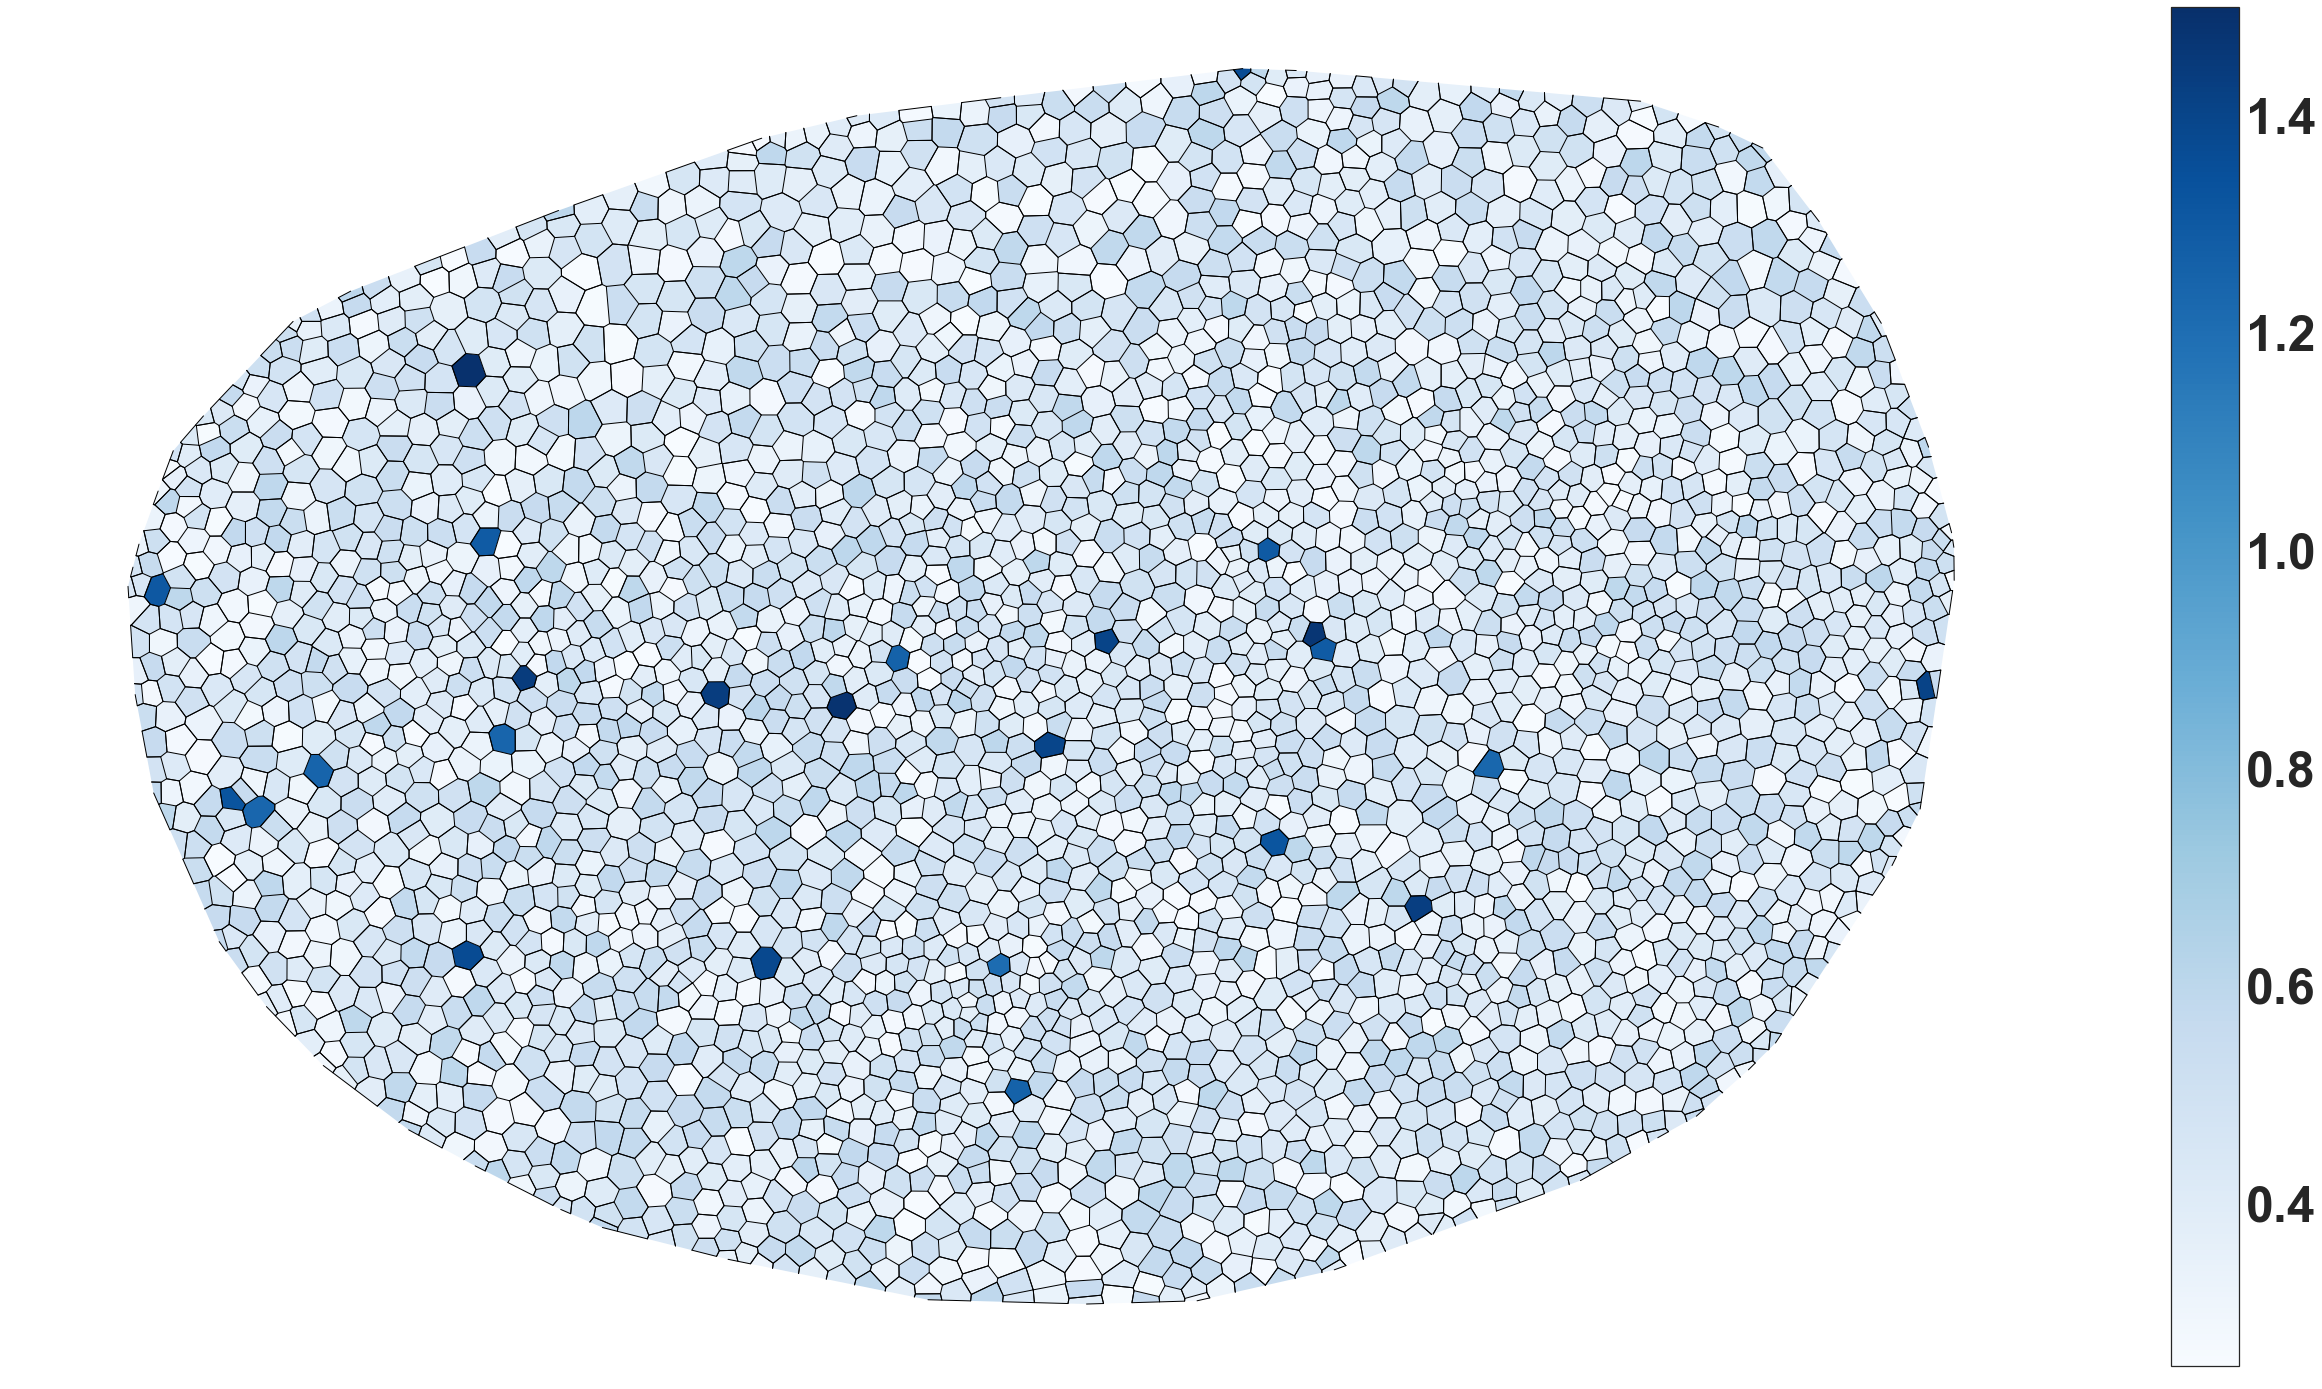

In [10]:
colormap = plt.cm.Blues
normalize = matplotlib.colors.Normalize(vmin=np.min(VPLC_state), vmax=max(np.max(VPLC_state),1.5))


with sns.axes_style("white"):
        fig=plt.figure(figsize=(45,25))
        #fig=plt.figure(figsize=(60,45))
        ax = fig.add_subplot(1,1,1)
        ax.axis('off')
        fig.patch.set_alpha(0.)
        sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
        sm._A = []
        cbar=fig.colorbar(sm, ax=ax)
        cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=50,fontweight="bold" )
        for cell in new_vertices:
            ax.plot(cell[:,0],cell[:,1], linewidth=1.0, color='k')
        for k in xrange(len(new_vertices)):
                cell=new_vertices[k]
                c=colors.to_hex(colormap(normalize(VPLC_state[k]))[0], keep_alpha=False)
                ax.fill(cell[:,0],cell[:,1], c)    

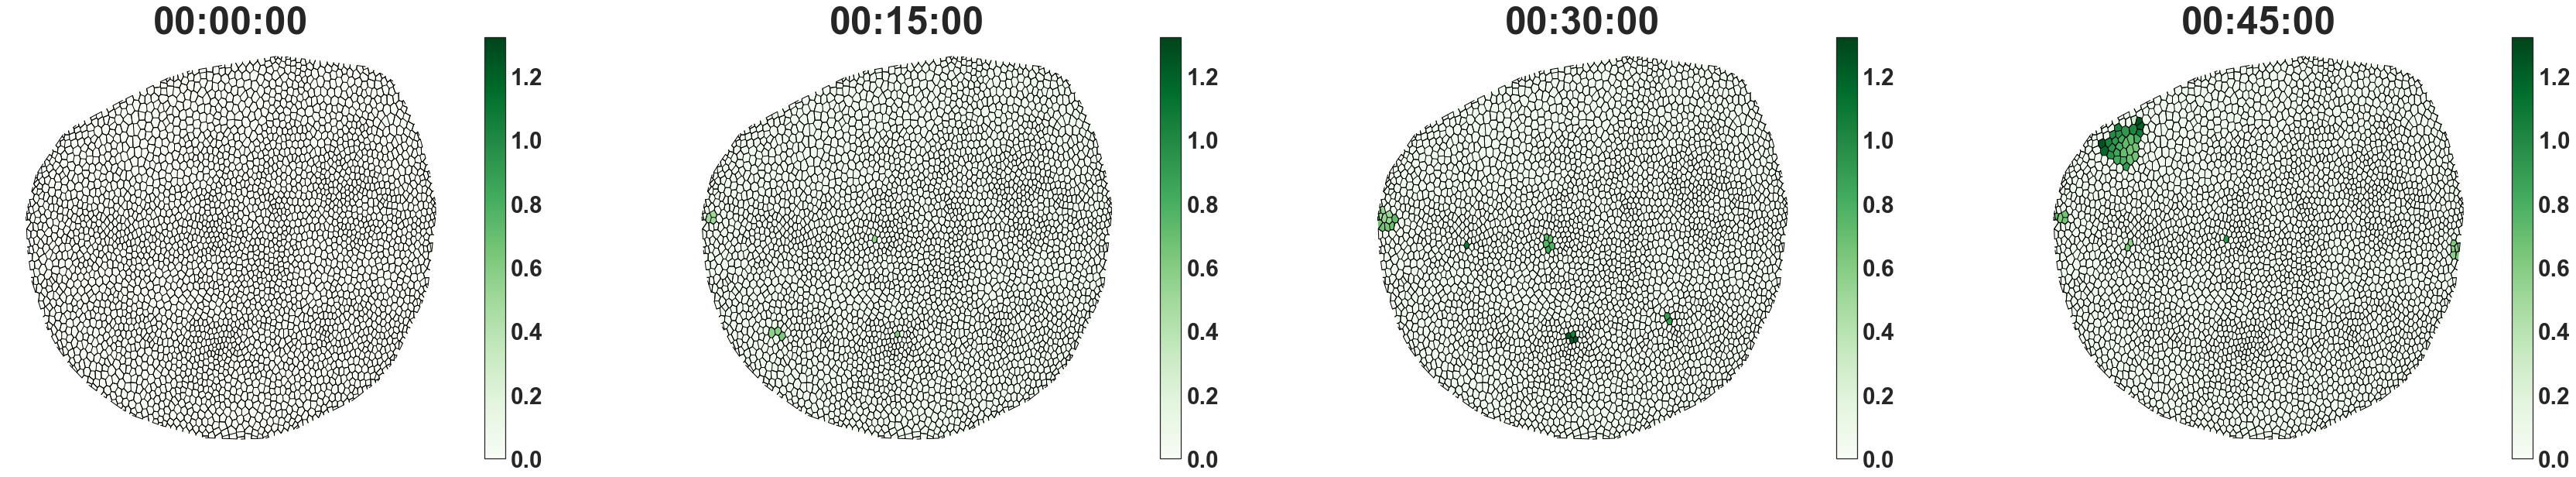

In [11]:
with sns.axes_style("white"):
    colormap = plt.cm.Greens
    normalize = matplotlib.colors.Normalize(vmin=np.min(disc_dynamics[:,0,:]), vmax=np.max(disc_dynamics[:,0,:]))
    row=1
    col=4
    g=itertools.product(xrange(row),xrange(col))
    fig=plt.figure(figsize=(col*15,row*10))
    j=0
    delta_j =4500
    for i in xrange(col*row):
        with sns.axes_style("white"):
            ix,iy=g.next()

            ax = plt.subplot2grid((row, col), ((ix), iy)) 
            ax.axis('off')
            for k in xrange(len(new_vertices)):
                cell=new_vertices[k]
                ax.plot(cell[:,0],cell[:,1], linewidth=1.0, color='k')
            for k in xrange(len(new_vertices)):
                cell=new_vertices[k]
                c=colors.to_hex(colormap(normalize(disc_dynamics[k,0,j])), keep_alpha=False)
                ax.fill(cell[:,0],cell[:,1], c)
            formated_time='00:{0:02.0f}:{1:02.0f}'.format(*divmod(j*dt , 60))
            ax.set_title( formated_time ,fontsize=50, fontweight="bold")
            j=j+delta_j
            #ax = plt.axes()
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
            sm._A = []
            cbar=fig.colorbar(sm, ax=ax)
            cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=30,fontweight="bold" )


#fig.savefig("./stochastic/time_lapse_"+str(sim_number)+".pdf",transparent=True, bbox_inches="tight")


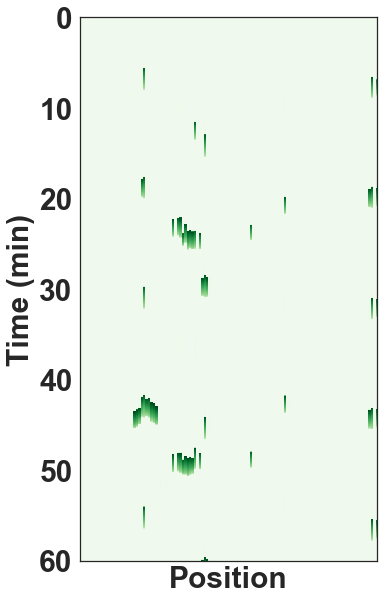

In [12]:
with sns.axes_style("white"):
    y_axis=centeriods[:,1]
    kymograp_index=np.where((y_axis<(-490)) & (y_axis>(-510)))

    colormap = plt.cm.Greens
    normalize = matplotlib.colors.Normalize(vmin=np.min(disc_dynamics[:,0,:]), vmax=np.max(disc_dynamics[:,0,:]))
    fig=plt.figure(figsize=(30,10))
    kymograph=disc_dynamics[kymograp_index,0,::][0][:,::2]
    kymograph=np.repeat(kymograph,40,axis=0)
    #kymograph=np.repeat(kymograph,16,axis=0)

    
    plt.imshow(kymograph.T,cmap=colormap)
    ax = plt.gca()
    #ax.set_yticks(np.arange(times[::50].size))
    #ax.set_yticklabels([-25,0,  10,20,30,40,50,60],fontsize=40, fontweight="bold")
    plt.yticks(np.arange(0,T/2,1498) , [0,  10,20,30,40,50,60],fontsize=30, fontweight="bold")
    plt.xticks([])
    plt.ylabel('Time (min)',fontsize=30,fontweight='bold')
    plt.xlabel('Position',fontsize=30,fontweight='bold')

    #fig.savefig("./stochastic/kymograph_"+str(sim_number)+".pdf",transparent=True, bbox_inches="tight")
del kymograph

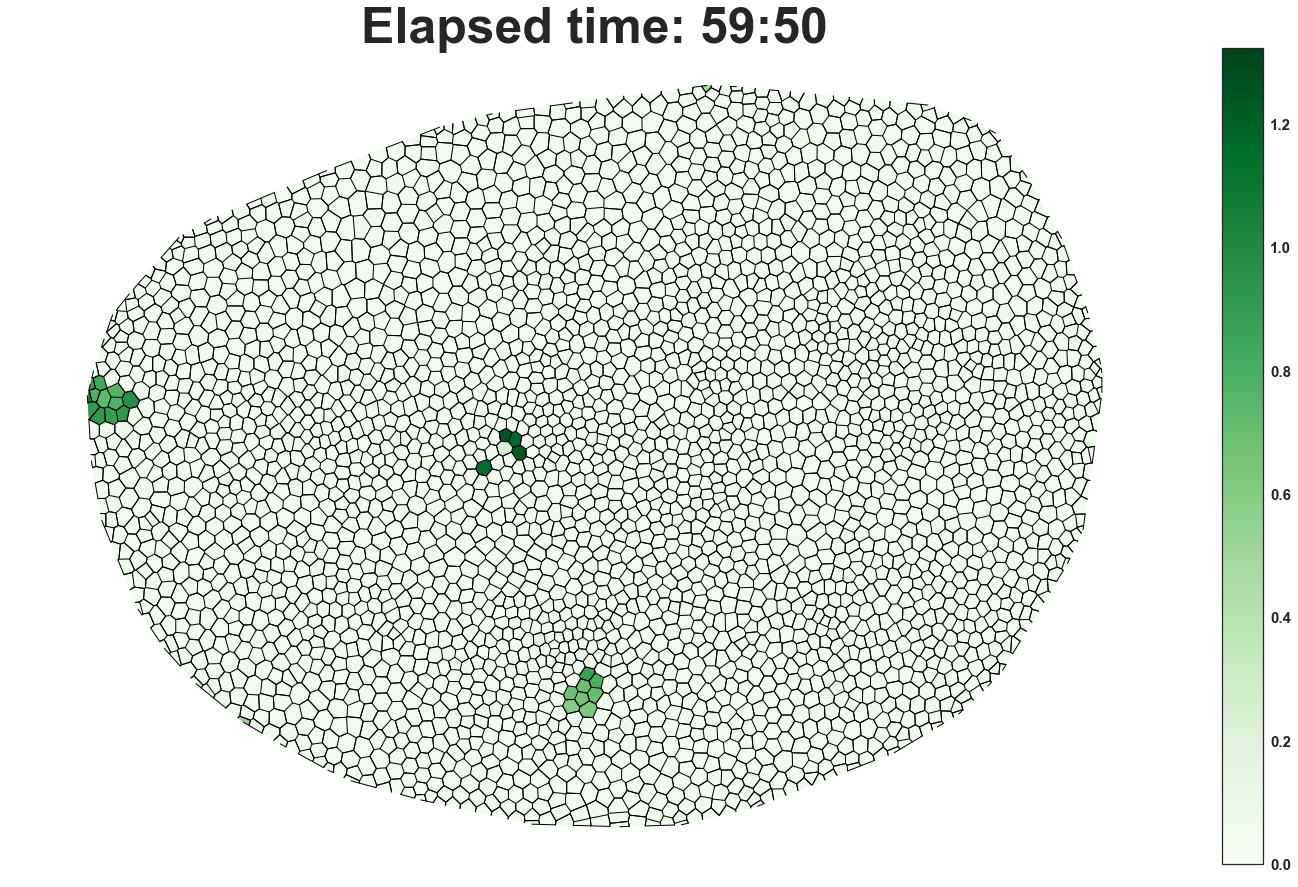

In [13]:
from fractions import Fraction

colormap = plt.cm.Greens
normalize = matplotlib.colors.Normalize(vmin=np.min(disc_dynamics[:,0,:]), vmax=max(np.max(disc_dynamics[:,0,:]),1))
my_color_map = {-1:'b', 0:'g',1:'r'}

with sns.axes_style("white"):
        fig=plt.figure(figsize=(25,15))
        fig.patch.set_alpha(0.)
        ax = fig.add_subplot(1,1,1)
        ax.axis('off')
        sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
        sm._A = []
        cbar=fig.colorbar(sm, ax=ax)
        cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")
        for cell in new_vertices:
            ax.plot(cell[:,0],cell[:,1], linewidth=1.0, color='k')
        patches = [matplotlib.patches.Polygon(verts) for verts in new_vertices ]
        def time_stamp_gen(n):
            j=0
            while j < n:
                yield "Elapsed time: "+'{0:02.0f}:{1:02.0f}'.format(*divmod(j*dt , 60))
                j+= 50
        time_stamps=time_stamp_gen(T)
        def init():
            return [ax.add_patch(p) for p in patches]
        
        
        def animate(frame,time_stamps):
            for j in xrange(len(patches)):
                c=colors.to_hex(colormap(normalize(frame[j])), keep_alpha=False)
                #c=my_color_map[frame[j]]
                patches[j].set_facecolor(c)
            ax.set_title( time_stamps.next() ,fontsize=50, fontweight="bold")
            return patches


        anim = animation.FuncAnimation(fig, animate, 
                                       init_func=init, 
                                       frames=disc_dynamics[:,0,::50].T, 
                                       fargs=(time_stamps,),
                                       interval=70,
                                       blit=True)

HTML(anim.to_html5_video())